In [1]:
script_idea = """
Script intended to train 1 NN for each drumtype, this is the SOFTMAX version.
Before training the model, you have to preprocess the songs and the annotations 
After processing, everything is going to EXP_PIPE_DATA (path, see bellow)
"""
print(script_idea)


Script intended to train 1 NN for each drumtype, this is the SOFTMAX version.
Before training the model, you have to preprocess the songs and the annotations 
After processing, everything is going to EXP_PIPE_DATA (path, see bellow)



In [3]:
# Which instrument you want to run the pipeline for; ie if target_label = "HH" -> create model for hihat. 
target_label = "HH"

# preprocess modules
import librosa
from librosa import display
import os,sys,re,pandas as pd,numpy as np
from scipy.io import wavfile
import math
from sympy import Interval
# viz
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
# sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score, recall_score, precision_score
# torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch
import torch.optim as optim
# other
import random
import logging
import glob
import warnings
from google.colab import drive
import sys

ROOT_DIR = "/content/drive"
#  Just use this if you are using google as a bucket
drive.mount(ROOT_DIR, force_remount=True)
# Don't forget to type My Drive before the whole path (in case you are using gdrive)
# In case you're not using gdrive; MUSIC_DIR should be your rootdir
MUSIC_DIR = os.path.join(ROOT_DIR,'My Drive/Maestria DM y KDD/Especializacion tesis/MDBDrums/MDB Drums')
AUDIO_DIR = os.path.join(MUSIC_DIR,'audio','drum_only')
ANNOTATIONS_DIR = os.path.join(MUSIC_DIR,'annotations','class')
# where your preprocessed data is for train & test (for the preprocesing script see )
EXP_PIPE_DATA = os.path.join(MUSIC_DIR,"pipe005_multiplemodelsdata_corrected_over60")
EXP_PIPE_DATA_TRAIN = os.path.join(EXP_PIPE_DATA,"train")
EXP_PIPE_DATA_TEST = os.path.join(EXP_PIPE_DATA,"test")

Mounted at /content/drive


In [4]:
%cd /content/drive/My Drive/Colab Notebooks/tesis_esp
import trainmodel_utils

/content/drive/My Drive/Colab Notebooks/tesis_esp


In [5]:
# reproductibility
myseed = 1995
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

In [6]:
#get filepaths
file_paths_txt_train = glob.glob(EXP_PIPE_DATA_TRAIN+"/*.txt")
file_paths_npy_train = glob.glob(EXP_PIPE_DATA_TRAIN+"/*.npy")
# we should this one in the evaluation script, not in this one
file_paths_txt_test = glob.glob(EXP_PIPE_DATA_TEST+"/*.txt")
file_paths_npy_test = glob.glob(EXP_PIPE_DATA_TEST+"/*.npy")
## ------------params ------------
train_ratio = 0.8
validation_ratio = 0.2 # you should use then after
# test_ratio = 0.0

In [9]:
logfile_path = os.path.join(EXP_PIPE_DATA,f'Softmax_CE_nn_model_{target_label}_logfile.log')
logging.basicConfig(filename = logfile_path, format='%(asctime)s %(levelname)s:%(message)s', level=logging.DEBUG, datefmt='%m/%d/%Y %I:%M:%S %p')
file_paths_txt_targeted,file_paths_npy_targeted = trainmodel_utils.filter_path_for_target_label(file_paths_txt_train,file_paths_npy_train,target_label)

# load all data in memory
labels_list,data_npy_list = trainmodel_utils.load_labels_and_data_from_npy(file_paths_npy_all = file_paths_npy_targeted)
data = trainmodel_utils.merge_numpy_data(data_npy_list) # X
labels = trainmodel_utils.merge_labels_data(labels_list) # y
assert data.shape[0] == len(labels)
print(f" Dataset is of {data.shape[0]} onsets, \n with a 33x9 (64-> window size, strides of 16 to a padded signal of len 128")
# x_train, x_val, x_test,y_train,y_val,y_test = trainmodel_utils.trainvaltest_split(data,labels,train_ratio,validation_ratio,test_ratio, myseed)
# remember: if none, then it will be stratified by y.
x_train, x_val, y_train, y_val = train_test_split(data,labels,test_size=validation_ratio,random_state=myseed, stratify = None)

User must verify if the following files correspoond eaco other :
 /content/drive/My Drive/Maestria DM y KDD/Especializacion tesis/MDBDrums/MDB Drums/pipe005_multiplemodelsdata_corrected_over60/train/MusicDelta_Disco_class__HH.txt 
 /content/drive/My Drive/Maestria DM y KDD/Especializacion tesis/MDBDrums/MDB Drums/pipe005_multiplemodelsdata_corrected_over60/train/MusicDelta_Disco_class__HH.npy
User must verify if the following files correspoond eaco other :
 /content/drive/My Drive/Maestria DM y KDD/Especializacion tesis/MDBDrums/MDB Drums/pipe005_multiplemodelsdata_corrected_over60/train/MusicDelta_Britpop_class__HH.txt 
 /content/drive/My Drive/Maestria DM y KDD/Especializacion tesis/MDBDrums/MDB Drums/pipe005_multiplemodelsdata_corrected_over60/train/MusicDelta_Britpop_class__HH.npy
User must verify if the following files correspoond eaco other :
 /content/drive/My Drive/Maestria DM y KDD/Especializacion tesis/MDBDrums/MDB Drums/pipe005_multiplemodelsdata_corrected_over60/train/Music

In [10]:
print("Data shape is:",data.shape)
print("Unique labels are:",set(labels))

Data shape is: (3247, 513, 17)
Unique labels are: {'HH', 'OTHER'}


In [11]:
# come from this unique_labels = list(set(labels)) 
unique_labels = [target_label,'OTHER']
unique_labels_idx = [idx for idx in range(len(unique_labels))]
unique_labels

['HH', 'OTHER']

In [12]:
def map_labels2idx(label_list2map, unique_labels):
  "map labels from unique_labels to its respective index"
  mapped_labels = [unique_labels.index(label_idx) for label_idx in label_list2map]
  return mapped_labels
  
def map_idx2labels(mapped_labels,unique_labels=unique_labels):
  labels = list()
  for idx in range(len(mapped_labels)):
    mapped_lab = mapped_labels[idx]
    label_name = unique_labels[mapped_lab]
    labels.append(label_name)
  return labels

In [13]:
labels_indexes = map_labels2idx(labels, unique_labels)
nclasses = len(unique_labels_idx)
print(labels[:5],labels_indexes[:5])

['HH', 'HH', 'HH', 'HH', 'OTHER'] [0, 0, 0, 0, 1]


In [14]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(myseed)

class Dataset(torch.utils.data.Dataset):
  """
  Data loader for mini batch processing in pytorch
  Based on https://stanford.edu/~shervine/blog/pytorch-how-to-generate-data-parallel 
  """
  def __init__(self, data_tensor, labels):
        'Initialization'
        self.labels = labels
        self.data_tensor = data_tensor

  def __len__(self):
        'Denotes the total number of samples'
        return len(self.labels)

  def __getitem__(self, index):
        'Generates one sample of data'
        X = self.data_tensor[index] #torch.tensor of 65x17 
        y = self.labels[index]
        return X, y

In [15]:
logging.info(f"Using the following random state for trainvaltest split: {myseed}")

In [16]:
y_train2idx = map_labels2idx(y_train, unique_labels)
data_tensor_train = torch.tensor(x_train, dtype=torch.float32)
N,H,W = data_tensor_train.shape
data_tensor_train = data_tensor_train.reshape(N,1,H,W)
print(f"trai ndataset shape: {data_tensor_train.shape}")

trai ndataset shape: torch.Size([2597, 1, 513, 17])


In [17]:
# validation
y_val2idx = map_labels2idx(y_val, unique_labels)
data_tensor_val = torch.tensor(x_val, dtype=torch.float32)
N,H,W = data_tensor_val.shape
data_tensor_val = data_tensor_val.reshape(N,1,H,W)
print(f"val ndataset shape: {data_tensor_val.shape}")

val ndataset shape: torch.Size([650, 1, 513, 17])


In [18]:
method = "meanstd_normalize"

if method == "meanstd_normalize":
  train_mean, train_std = data_tensor_train.mean(), data_tensor_train.std()
  normalize_train_data = {"mean":train_mean, "std":train_std}
  meanstd_normalize = torchvision.transforms.Normalize(**normalize_train_data, inplace=False) 
  print(f"applying {method}")
  data_tensor_train_norm = meanstd_normalize(data_tensor_train)
  data_tensor_val_norm = meanstd_normalize(data_tensor_val)
elif method == "minmax_normalize":
  train_max,trainmin = data_tensor_train.max(),data_tensor_train.min()
  train_maxmin_diff  =train_max-trainmin
  minmax_normalize = torchvision.transforms.Normalize(mean = trainmin, std = train_maxmin_diff, inplace=False) 
  print(f"applying {method}")
  data_tensor_train_norm = minmax_normalize(data_tensor_train)
  data_tensor_val_norm = minmax_normalize(data_tensor_val)
else:
  pass

applying meanstd_normalize


In [19]:
# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True

# Parameters
params = {'batch_size': 128,
          'shuffle': True,
          'num_workers': 2}
n_epochs = 30

# Generators
training_set = Dataset(data_tensor_train_norm, y_train2idx)
training_generator = torch.utils.data.DataLoader(training_set, **params)

validation_set  = Dataset(data_tensor_val_norm, y_val2idx)
validation_generator = torch.utils.data.DataLoader(validation_set, **params)

In [20]:
nexamples2show = 5
testiter = iter(training_set) #start the iterator
for i in range(nexamples2show):
  first_x,first_y = next(testiter)
  print(f"Observation nubmer {i} has labelidx:{first_y} and shape {first_x.shape}")
 

Observation nubmer 0 has labelidx:1 and shape torch.Size([1, 513, 17])
Observation nubmer 1 has labelidx:1 and shape torch.Size([1, 513, 17])
Observation nubmer 2 has labelidx:0 and shape torch.Size([1, 513, 17])
Observation nubmer 3 has labelidx:1 and shape torch.Size([1, 513, 17])
Observation nubmer 4 has labelidx:0 and shape torch.Size([1, 513, 17])


In [21]:
#https://towardsdatascience.com/beginners-guide-to-loading-image-data-with-pytorch-289c60b7afec

def evaluate_data_pytorch(data_generator:torch.utils.data.DataLoader,pytorch_net,sklearnmetric:str ='classification_report') ->str:
  """
  Function for evaluating validation set using torch dataloader. 
  taken/based on https://towardsdatascience.com/beginners-guide-to-loading-image-data-with-pytorch-289c60b7afec
  Params:
    data_generator -> must be pytorch generator 
    pytorch_net: -> pytorch neural network
    sklearnmetric: sklearn metric that requires y_true and y_pred ; could be classification_report or f1_score or other
  """
  #data_generator = validation_generator
  truelabels_val,predictedlabels_val = list(),list()
  # since we're not training, we don't need to calculate the gradients for our outputs
  with torch.no_grad():
      for i, data in enumerate(data_generator, 0):
          # get the inputs; data is a list of [inputs, labels]
          if not cuda:
            inputs, labels = data
          if cuda:
            inputs, labels = data[0].to(device), data[1].to(device)
          # forward + backward + optimize
          #print(inputs.shape)
          outputs = net(inputs)

          # the class with the highest energy is what we choose as prediction
          _, predicted = torch.max(outputs.data, 1)
          #print(predicted)
          #total += labels.size(0)
          truelabels_val.extend(labels.tolist())
          predictedlabels_val.extend(predicted.tolist())
          #correct += (predicted == labels).sum().item()
  df_val = pd.DataFrame({"truelabel":truelabels_val,"predicted":predictedlabels_val})
  df_val["lab_truelabel"] = map_idx2labels(df_val["truelabel"].tolist())
  df_val["lab_predicted"] = map_idx2labels(df_val["predicted"].tolist())
  pd.crosstab(df_val["lab_truelabel"],df_val["lab_predicted"])

  if sklearnmetric == "classification_report":
    cr = classification_report(y_true=df_val["lab_truelabel"].tolist(),y_pred=df_val["lab_predicted"].tolist(), output_dict = True)
  elif sklearnmetric == "f1_score_weighted":
    cr = f1_score(y_true=df_val["lab_truelabel"].tolist(),y_pred=df_val["lab_predicted"].tolist(),average = 'weighted')
  else:
    raise ValueError("Please  sklearn metric mustbe classification_report or f1_score with avergage weighted")      
  return cr

# Define network architecture (cnn)

In [22]:
cuda = False
import torch.nn as nn

class Net(nn.Module):
    def __init__(self,nchannels,nclasses, unique_labels, meanstd_normalize):
        """
        Params:
          unique_labels: list of labels to be mapped; example: ['OTHER','KD'] 
          meanstd_normalize:  output from torchvision.transforms.Normalize; for zscaling 
              o             the data
          prediction_threshold: float in (0,1) interval; if proba>threshold then
                        predicted class will be TARGET else other. 
          nclasses of the net; 2 in this case since we are applying binary classif
        """
        # start
        super().__init__()
        # this is the normalizer to used in the predictor then
        self.meanstd_normalizer = torchvision.transforms.Normalize(**meanstd_normalize, inplace=False) 
        # remove it if you want to this is jsut for cleaner predictions (use labels instead of etc)
        self.unique_labels = unique_labels
        # other attributes
        self.nchannels = nchannels
        self.nclasses = nclasses
        self.conv1 = nn.Conv2d(self.nchannels, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(2000, 120)
        self.dropout1 = nn.Dropout(p=0.5, inplace=False)
        self.fc2 = nn.Linear(120, 84)
        #self.dropout2 = nn.Dropout(p=0.3, inplace=False)
        self.fc3 = nn.Linear(84, self.nclasses)
    def forward(self, x):
        "Prints are commented for debugging purposes"
        # conv1 
        x = self.conv1(x)
        #print("Conv1:",x.shape)
        x =F.relu(x)
        x = self.pool(x)
        #print("Pool1:",x.shape)
        x = self.conv2(x)
        #print("Conv2:",x.shape)
        x = F.relu(x)
        x = self.pool(x)
        #print("Pool2:",x.shape)
        # flatten  all dims except the batch; 
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        #print("Flattened, except batch:",x.shape)
        x = self.fc1(x)
        x=F.relu(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        # pass over relu
        x = F.relu(x)
        #
        #x = self.dropout2(x)
        # pass over fc3 omg
        x = self.fc3(x)
        #https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss
        return x
    def map_idx2labels(self,mapped_labels,unique_labels):
      labels = list()
      for idx in range(len(mapped_labels)):
        mapped_lab = mapped_labels[idx]
        label_name = unique_labels[mapped_lab]
        labels.append(label_name)
      return labels

    def predict(self,x_batch):
      """
      Final prediction function
      params:
        x_batch -> np.array model dimensions data_lenx513x17 data
      return: mapped prediction (either target label or other)
      """
      #x_batch = x_test[:10].copy()
      #N = len(x_batch)
      data_tensor = torch.tensor(x_batch, dtype=torch.float32)
      N,H,W = data_tensor.shape
      print(N,H,W)
      data_tensor = data_tensor.reshape(N,1,H,W)
      # noramalize data
      data_tensor = self.meanstd_normalizer(data_tensor)
      #forward pass
      predictions = self.forward(data_tensor)
      # calculate the .max(1) for each batch and convert them to list
      predictions = predictions.argmax(1).tolist()
      predictions2labels = self.map_idx2labels(predictions,self.unique_labels)
      return predictions2labels

#todo
net = Net(nchannels=1,nclasses=nclasses, unique_labels=unique_labels, meanstd_normalize=normalize_train_data)
if cuda:
  net.to(device)

# Start training the net without early stopping (n_epochs = 10 just for the example)

In [23]:
f1_train_list,f1_val_list,epoch_number = list(),list(),list()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0)
metric2monitor = "f1-score"
#optimizer = optim.Adam(net.parameters(), lr=0.01)
for epoch in range(n_epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(training_generator, 0):
        # get the inputs; data is a list of [inputs, labels]
        if not cuda:
          inputs, labels = data
        if cuda:
          inputs, labels = data[0].to(device), data[1].to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        # if i % 2000 == 1999:    # print every 2000 mini-batches
        #   print(outputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()


    cr_train = evaluate_data_pytorch(training_generator,pytorch_net = net,sklearnmetric='classification_report')[target_label][metric2monitor]
    cr_val = evaluate_data_pytorch(validation_generator,pytorch_net = net,sklearnmetric='classification_report')[target_label][metric2monitor]
    f1_train_list.append(cr_train)
    f1_val_list.append(cr_val)
    epoch_number.append(epoch)
    print(f" [INFO] Epoch number: {epoch}")
print('[INFO] Finished Training')

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 [INFO] Epoch number: 0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 [INFO] Epoch number: 1
 [INFO] Epoch number: 2
 [INFO] Epoch number: 3
 [INFO] Epoch number: 4
 [INFO] Epoch number: 5
 [INFO] Epoch number: 6
 [INFO] Epoch number: 7
 [INFO] Epoch number: 8
 [INFO] Epoch number: 9
 [INFO] Epoch number: 10
 [INFO] Epoch number: 11
 [INFO] Epoch number: 12
 [INFO] Epoch number: 13
 [INFO] Epoch number: 14
 [INFO] Epoch number: 15
 [INFO] Epoch number: 16
 [INFO] Epoch number: 17
 [INFO] Epoch number: 18
 [INFO] Epoch number: 19
 [INFO] Epoch number: 20
 [INFO] Epoch number: 21
 [INFO] Epoch number: 22
 [INFO] Epoch number: 23
 [INFO] Epoch number: 24
 [INFO] Epoch number: 25
 [INFO] Epoch number: 26
 [INFO] Epoch number: 27
 [INFO] Epoch number: 28
 [INFO] Epoch number: 29
[INFO] Finished Training


In [24]:
df_train = pd.DataFrame({"f1_score":f1_train_list,"epoch":epoch_number,"dataset_type":"training"})
df_val = pd.DataFrame({"f1_score":f1_val_list,"epoch":epoch_number,"dataset_type":"validation"})
df_trainval = pd.concat([df_train,df_val],axis=0)
fig = px.line(df_trainval, x="epoch", y="f1_score", color='dataset_type')
fig.show()

In [28]:
df_trainval = df_trainval.reset_index(drop=True)

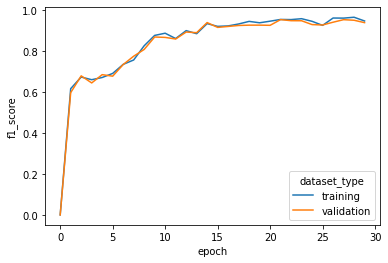

In [29]:
figpath2save = os.path.join(EXP_PIPE_DATA,f"refactored_example_for_github_nn_fig_model_{target_label}.jpeg")
sns_plot = sns.lineplot(x = df_trainval["epoch"], y = df_trainval["f1_score"] , hue = df_trainval["dataset_type"])
fig = sns_plot.get_figure()
fig.savefig(figpath2save)
fig.show()

In [30]:
modelpath2save = os.path.join(EXP_PIPE_DATA,f"refactored_example_for_github_nn_model_{target_label}.pth")
torch.save(net,modelpath2save)

In [33]:
mm = torch.load(modelpath2save)
mm

Net(
  (meanstd_normalizer): Normalize(mean=0.14862293004989624, std=1.0505046844482422)
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=2000, out_features=120, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)